In [1]:
from bs4 import BeautifulSoup
from shapely.geometry import Polygon

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
images = []
files = ['batch1.xml', 'batch2.xml', 'batch3.xml', 'batch4.xml']
for file in files:
    with open(file, 'r') as f:
        soup = BeautifulSoup(f.read(), "xml")
        for img in soup.find_all('image'):
            water_hyacinths = 0

            height = int(img.get('height'))
            width = int(img.get('width'))
            img_area = height * width 
            river_area = None
            water_hyacinths = []
            garbage = []
            boats = []
            others = []

            for polygon in img.find_all('polygon'):
                if(polygon.get('label') == 'river'):
                    coords = [p.split(',') for p in polygon.get('points').split(';')]

                    river_area = Polygon(coords).area
                elif(polygon.get('label') == 'object'):
                    coords = [p.split(',') for p in polygon.get('points').split(';')]
                    if(polygon.find('attribute').text == 'water hyacinth'):
                        water_hyacinths.append('%.2f' % Polygon(coords).area)
                    elif(polygon.find('attribute').text == 'garbage'):
                        garbage.append('%.2f' % Polygon(coords).area)
                    elif(polygon.find('attribute').text == 'boat'):
                        boats.append('%.2f' % Polygon(coords).area)
                    elif(polygon.find('attribute').text == 'others'):
                        others.append('%.2f' % Polygon(coords).area)
            
            images.append({
                'name': img.get('name'),
                'height': height,
                'width': width,
                'area': img_area,
                'river_area': river_area,
                'river_relative_to_image': river_area / img_area if river_area else None,
                'water_hyacinths': ','.join(water_hyacinths),
                'wh_count': len(water_hyacinths),
                'garbage': ','.join(garbage),
                'g_count': len(garbage),
                'boats': ','.join(boats),
                'b_count': len(boats),
                'others': ','.join(others),
                'o_count': len(others),
            })

In [3]:
df = pd.DataFrame(images)

df.head()

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,wh_count,garbage,g_count,boats,b_count,others,o_count
0,098a1d68568bc.jpg,2250,4000,9000000,7.109300e+06,0.789922,"988.12,700.06,2158.59,1601.45,450.63,212.82,11...",8,,0,,0,,0
1,0bcf8ec7197b6.jpg,2250,4000,9000000,5.248960e+06,0.583218,"372.59,2111.14,3491.98,3261.25,250.78",5,,0,,0,,0
2,10b9ed1b6f7a1.jpg,6000,8000,48000000,1.912334e+05,0.003984,"9387.88,1263.40,2384.67,3037.19,504.41,3545.15...",7,,0,,0,,0
3,1488a698e63bd.jpg,2250,4000,9000000,6.838209e+06,0.759801,"731.12,833.01,673.73",3,,0,,0,,0
4,154f0cb77c45e.jpg,2250,4000,9000000,7.526385e+06,0.836265,"222.14,492.94",2,,0,,0,,0


In [4]:
df.to_json('annotation_statistics.json', orient='records')

In [5]:
df = pd.read_json('annotation_statistics.json')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     360 non-null    object 
 1   height                   360 non-null    int64  
 2   width                    360 non-null    int64  
 3   area                     360 non-null    int64  
 4   river_area               358 non-null    float64
 5   river_relative_to_image  358 non-null    float64
 6   water_hyacinths          360 non-null    object 
 7   wh_count                 360 non-null    int64  
 8   garbage                  360 non-null    object 
 9   g_count                  360 non-null    int64  
 10  boats                    360 non-null    object 
 11  b_count                  360 non-null    int64  
 12  others                   360 non-null    object 
 13  o_count                  360 non-null    int64  
dtypes: float64(2), int64(7), o

In [6]:
df[df['river_area'] != df['river_area']]

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,wh_count,garbage,g_count,boats,b_count,others,o_count
61,cef68f7b66cd5.jpg,2250,4000,9000000,NaN,NaN,"319.85,385.59,7053354.98,158.01,263.64",5,,0,,0,,0
222,d0dc4afc5109f.jpg,1440,2560,3686400,NaN,NaN,"516.93,109.81,243.59,1132.62,116.32,176.41,92....",16,"968.79,185.43,204.96,384.61,121.88,140.49,330....",16,,0,,0


In [7]:
df['resolution'] = df.apply(lambda x: '%dx%d' % (x['height'], x['width']), axis=1)

Text(0.5, 1.0, 'Number of Images per Resolution')

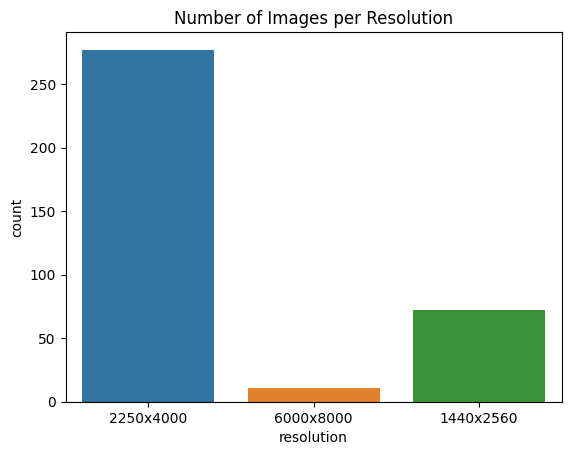

In [8]:
sns.countplot(df, x='resolution')

plt.title('Number of Images per Resolution')

In [9]:
df[df['river_relative_to_image'] < 0.5]

,name,height,width,area,river_area,river_relative_to_image,water_hyacinths,wh_count,garbage,g_count,boats,b_count,others,o_count,resolution
2,10b9ed1b6f7a1.jpg,6000,8000,48000000,1.912334e+05,0.003984,"9387.88,1263.40,2384.67,3037.19,504.41,3545.15...",7,,0,,0,,0,6000x8000
17,3c00c792e62bd.jpg,6000,8000,48000000,3.062712e+03,0.000064,"470.94,2984.87,2947.30,8503.99",4,,0,,0,,0,6000x8000
19,3cee913a8e627.jpg,2250,4000,9000000,4.246180e+06,0.471798,"1982.69,1759.92,4480.71,4176.67,3152.23,14368....",7,,0,,0,,0,2250x4000
34,621ede2509ce8.jpg,2250,4000,9000000,6.244145e+03,0.000694,1079.20,1,,0,,0,,0,2250x4000
36,654be90a139c2.jpg,2250,4000,9000000,7.660048e+02,0.000085,"248.09,9286.97,541703.76,988.56,10415.04",5,,0,,0,,0,2250x4000
51,9af65325b6362.jpg,2250,4000,9000000,4.240158e+03,0.000471,"388.40,2263417.57,11300.88,14127.45,517.65,709.62",6,,0,,0,,0,2250x4000
55,a45229c7ea87c.jpg,2250,4000,9000000,4.175424e+06,0.463936,"1157.77,897.59,35160.09,655.84,3241.72",5,,0,,0,,0,2250x4000
72,fb92d0f220ba3.jpg,2250,4000,9000000,1.408815e+03,0.000157,"511.99,117.75,505.76,5511.47",4,,0,,0,,0,2250x4000
174,0809051412264.jpg,1440,2560,3686400,1.821153e+06,0.494019,"432.98,85.59,339.21",3,"40.93,803.85",2,,0,,0,1440x2560
187,73244ae953d8e.jpg,1440,2560,3686400,1.252375e+03,0.000340,"95.48,41.70,346.01,416.47,327.84,19.43,77.47,1...",9,"43.77,58.88,102.04,50.66,99.05,59.48",6,,0,,0,1440x2560


<AxesSubplot: xlabel='wh_count', ylabel='Count'>

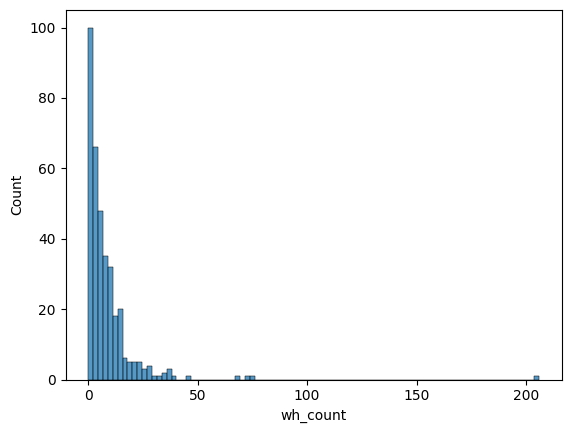

In [10]:
sns.histplot(df, x='wh_count')

<AxesSubplot: xlabel='g_count', ylabel='Count'>

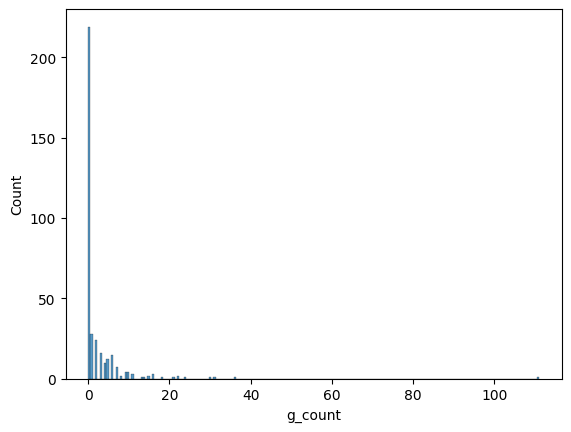

In [11]:
sns.histplot(df, x='g_count')

<AxesSubplot: xlabel='b_count', ylabel='Count'>

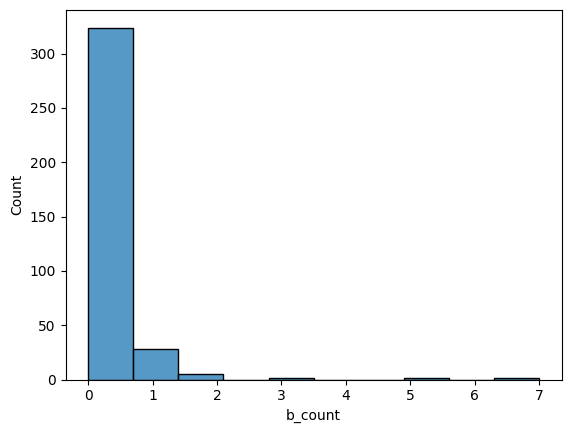

In [12]:
sns.histplot(df, x='b_count')

<AxesSubplot: xlabel='o_count', ylabel='Count'>

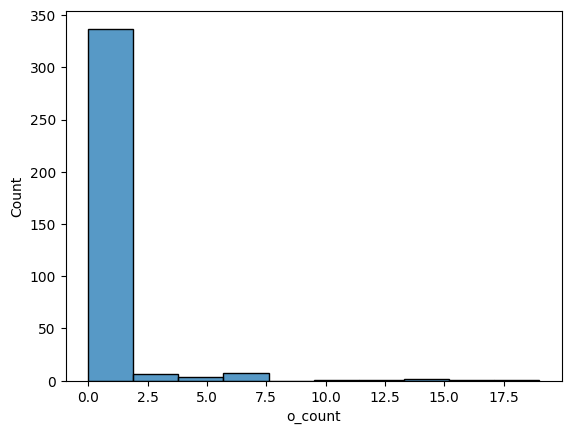

In [13]:
sns.histplot(df, x='o_count')